# Homework 2 - Recurrent Neural Networks

In this part of the homework we are going to work with Recurrent Neural Networks, in particular GRU. One of the greatest things that Recurrent Neural Networks can do when working with sequences is retaining data from several timesteps in the past. We are going to explore that property by constructing an 'echo' Recurrent Neural Network.

The goal here is to make a model that given a sequence of letters or digits will output that same sequence, but with a certain delay. Let's say the input is a string 'abacaba', we want the model to not output anything for 3 steps (delay length), and then output the original string step by step, except the last 3 characters. So, target output is then 'XXXabac', where 'X' is empty output.

This is similar to [this notebook](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/09-echo_data.ipynb) (which you should refer to when doing this assignment), except we're working not with a binary string, but with a sequence of integers between 0 and some N. In our case N is 26, which is the number of letters in the alphabet.

## Dataset

Let's implement the dataset. In our case, the data is basically infinite, as we can always generate more examples on the fly, so don't need to load anything from disk.

In [215]:
import math
import random
import string

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange

torch.manual_seed(1);

# Max value of the generated integer. 26 is chosen becuase it's`1 `
# the number of letters in English alphabet.
N = 26
D = 4

def idx_to_onehot(x, k=N+1):
  """ Converts the generated integers to one-hot vectors """
  ones = torch.sparse.torch.eye(k)
  shape = x.shape
  res = ones.index_select(0, x.view(-1).type(torch.int64))
  return res.view(*shape, res.shape[-1])

def onehot_to_idx(x):
    return torch.argmax(x, dim=2)

class EchoDataset(torch.utils.data.IterableDataset):

  def __init__(self, delay=4, seq_length=15, size=1000, batch_size=32):
    self.delay = delay
    self.seq_length = seq_length
    self.size = size
    self.batch_size = batch_size
  
  def __len__(self):
    return (self.size + self.batch_size - 1) // self.batch_size

  def __iter__(self):
    """ Iterable dataset doesn't have to implement __getitem__.
        Instead, we only need to implement __iter__ to return
        an iterator (or generator).
    """
    ctr = self.size
    while ctr > 0:
      inp = []
      targ = []
      for _ in range(min(self.batch_size, ctr)):
        seq = torch.tensor([random.choice(range(1, N + 1))\
          for i in range(self.seq_length)], dtype=torch.int64)
        result = torch.cat((torch.zeros(self.delay),\
          seq[:self.seq_length - self.delay])).type(torch.int64)
        inp.append(seq)
        targ.append(result)
        ctr -= 1
      yield torch.stack(inp), torch.stack(targ)
    assert ctr == 0, f'Counter: {ctr}'


# Using large batch sizes leads to getting stuck in local minima
DELAY = 4
DATASET_SIZE = 4000
#DATASET_SIZE = 100000
BATCH_SIZE = 32
ds = EchoDataset(delay=DELAY, size=DATASET_SIZE, batch_size=BATCH_SIZE)

In [216]:
batch_one = next(iter(ds))
item = 0
batch_one[0][item], idx_to_onehot(batch_one[0][item])
batch_one[1][item], idx_to_onehot(batch_one[1][item])
#idx_to_onehot('')

(tensor([ 0,  0,  0,  0,  2, 21, 19, 13,  2, 19, 10, 17,  4, 18, 12]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 

## Model

Now, we want to implement the model. For our purposes, we want to use GRU. The architecture consists of GRU and a decoder. Decoder is responsible for decoding the GRU hidden state to yield a predicting for the next output. The parts you are responsible for filling with your code are marked with `TODO`. 

In [217]:
class GRUCell(nn.Module):
  def __init__(self, input_size, hidden_size, delay_size=0):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.delay_size = delay_size
    self.in_dim = input_size + hidden_size + delay_size
    self.out_dim = hidden_size
    self.reset_gate = nn.Linear(self.in_dim, self.out_dim)
    self.update_gate = nn.Linear(self.in_dim, self.out_dim)
    self.hidden_gate = nn.Linear(self.in_dim, self.out_dim)
    self.tanh = nn.Tanh()
    self.act = nn.ReLU()
    
  def forward(self, x, h, delay=None):
    #print(f'GRUCell input shapes x: {x.shape} h: {h.shape}')
    assert x.shape[-1] == self.input_size
    assert h.shape[-1] == self.hidden_size
    if delay is not None:
      assert delay.shape[-1] == self.delay_size
    assert x.device == h.device, f'X device: {x.device} h device: {h.device}'
    if delay is not None:
      assert x.device == delay.device,\
        f'X device: {x.device} delay device {delay.device}'
    inp = torch.cat([x, h], dim=1)
    if delay is not None:
      if len(delay.shape) == 1:
        delay = delay.unsqueeze(1)
      inp = torch.cat([inp, delay], dim=1)
    assert x.device == inp.device,\
      f'X device: {x.device} Inp device: {inp.device}'
    z_t = self.act(self.update_gate(inp))
    r_t = self.act(self.reset_gate(inp))
    r_t_h = r_t * h.clone()
    inp = torch.cat([x, r_t_h], dim=1)
    if delay is not None:
      inp = torch.cat([inp, delay], dim=1)
    z_t_diff = 1 - z_t
    z_t_h = z_t_diff * h.clone()
    tanh_out = self.tanh(self.hidden_gate(inp))
    z_t_inp = z_t * tanh_out
    h_t = z_t_h + z_t_inp 
    return h_t, h_t

class GRULayer(nn.Module):
  def __init__(self, input_size, hidden_size, delay_size=0, batch_first=True):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.delay_size = delay_size
    self.batch_first = batch_first
    self.gru_cell = GRUCell(input_size, hidden_size, delay_size)
    
  def forward(self, x, h, delay=None):
    #print(f'GRULayer X shape: {x.shape} h shape: {h.shape}')
    seq_len = x.shape[1] if self.batch_first else x.shape[0]

    out = []
    for i in range(seq_len):
      # print(f'GRULayer forward iteration {i}')
      if self.batch_first:
        y, h = self.gru_cell(x[:,i], h, delay)
      else:
        y, h = self.gru_cell(x[i], h, delay)
      out.append(y)
    out = torch.stack(out, dim=1 if self.batch_first else 0)
    # print(f'GRU forward out shape: {out.shape}')
    return out, h

In [218]:
class GRUBase(nn.Module):
  def __init__(
      self, input_size, hidden_size, output_size, layers, device,
      delay_size=0, batch_first=True):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.delay_size = delay_size
    self.num_layers = layers
    self.device = device
    self.batch_first=batch_first
    self.lut = {l:  i for i, l in enumerate(string.ascii_lowercase, 1)}
    self.lut[' '] = 0
    self.reverse_lut = {v: k for k, v in self.lut.items()}
    self.h = None

  def init_hidden_state(self, batch_size):
    if self.batch_first:
        self.h = torch.zeros(batch_size, self.num_layers, self.hidden_size)
    else:
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
    self.h = self.h.to(self.device)

  def forward(self, x, delays=None):
    raise NotImplementedError

  @torch.no_grad()
  def test_run(self, s, delay=None):
    # This function accepts one string s containing lowercase characters a-z. 
    # You need to map those characters to one-hot encodings, 
    # then get the result from your network, and then convert the output 
    # back to a string of the same length, with 0 mapped to ' ', 
    # and 1-26 mapped to a-z.
    self.init_hidden_state(1)

    indices = torch.Tensor([self.lut[let] for let in s])    
    one_hot = idx_to_onehot(indices).to(self.device)
    unsqueeze_dim = 0 if self.batch_first else 1
    one_hot = one_hot.unsqueeze(unsqueeze_dim)
    if delay is not None:
      delay_tensor = torch.Tensor([delay])
      delay_one_hot = idx_to_onehot(
        delay_tensor, self.delay_size).to(self.device)
    else:
      delay_one_hot = None
    y = self.forward(one_hot, delay_one_hot)
    indices = y.squeeze().argmax(dim=1)
    out = ''.join([self.reverse_lut[idx.item()] for idx in indices])
    return out

In [219]:

class GRUMemory(GRUBase):
  def __init__(
      self, input_size, hidden_size, output_size, layers, device):
    super().__init__(input_size, hidden_size, output_size, layers, device)
    self.gru_layer1 = GRULayer(input_size, hidden_size)
    self.gru_layer2 = GRULayer(hidden_size, hidden_size)
    self.linear = nn.Linear(hidden_size, output_size)
    self.layers = [self.gru_layer1, self.gru_layer2]

  def forward(self, x, delays=None):
    # inputs: x - input tensor of shape (batch_size, seq_length, N+1)
    # returns:
    # logits (scores for softmax) of shape (batch size, seq_length, N + 1)
    assert self.h is not None
    batch_size = x.shape[0]
    out = x
    for i in range(self.num_layers):
      layer = self.layers[i]
      out, h = layer(out, self.h[:batch_size, i])
      self.h[:batch_size, i] = h.detach()
    out = self.linear(out)
    return out

In [220]:
class GRU(GRUBase):
    def __init__(self, input_size, hidden_size, output_size,
        num_layers, device, dropout=0.0):
        super().__init__(input_size, hidden_size, output_size, num_layers,
            device)
        self.gru = nn.GRU(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, bias=True,
            batch_first=True, dropout=dropout, bidirectional=False)
        self.linear = nn.Linear(
            in_features=hidden_size, out_features=output_size)

    def init_hidden_state(self, batch_size):
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        self.h = self.h.to(self.device)

    def forward(self, x, delays=None):
       assert self.h is not None
       batch_size = x.shape[0]
       out, h = self.gru(x, self.h[:,:batch_size].contiguous())
       out = self.linear(out)
       self.h = h.detach()
       return out

## Training
Below you need to implement the training of the model. We give you more freedom as for the implementation. The two limitations are that it has to execute within 10 minutes, and that error rate should be below 1%.

In [221]:
def train(data_stream, num_epochs, model, optimizer, criterion, batch_size,
    device='cpu', has_delay=False, batch_first=True, delay_size=9,
    verbose=False):
    model.train()
    epoch_bar = tqdm(range(num_epochs))
    train_losses = []
    train_accuracies = []
    correct = []
    cumulative_loss = []
    for i in epoch_bar:
        correct = []
        total = 0
        cumulative_loss = []
        correct_thresh = 0.73
        #model.init_hidden_state(batch_size)
        for it_ in tqdm(data_stream, leave=False):
            if has_delay:
                data, delays, target = it_
                delays_one_hot = idx_to_onehot(delays, delay_size)
                delays_one_hot = delays_one_hot.to(device)
            else:
                data, target = it_
                delays = None
                delays_one_hot = None
            model.init_hidden_state(data.shape[0 if batch_first else 1])
            data_one_hot = idx_to_onehot(data)
            data_one_hot = data_one_hot.to(device)
            target_one_hot = idx_to_onehot(target)
            target_one_hot = target_one_hot.to(device)
            optimizer.zero_grad()
            logits = model.forward(data_one_hot, delays_one_hot)
            if verbose:
                print(f'Train iteration {i} Logits shape: {logits.shape}')
                print(f'{logits}')
            pred = logits.sigmoid().argmax(dim=2)
            loss = criterion(logits, target_one_hot)
            
            if verbose:
                print(f'Train iteration {i} Loss: {loss.shape}')
                print(f'{loss}')
            
            loss.backward()
            optimizer.step()
            output = pred
            perc_correct = (output.cpu() == target).float().mean().item()
            if verbose:
                print(f'Percent correct {perc_correct}')
                print(f'Output shape: {output.shape} Target shape: {target.shape}')
                print(f'Output: {output} Target: {target}')
            
            if perc_correct > correct_thresh:
                correct_thresh = perc_correct
                
            cumulative_loss.append(loss.item())
            correct.append(perc_correct)
            total += 1

        mean_loss = sum(cumulative_loss)/total
        mean_correct = sum(correct)/total
        train_losses.append(mean_loss)
        train_accuracies.append(mean_correct)
        epoch_bar.set_postfix(
            {
                'accuracy': mean_correct,
                'loss': mean_loss,
            }
        )
    
    if verbose:
        print(f'Cumulative_loss: {cumulative_loss}')
    plt.figure(dpi=200)
    plt.subplot(121)
    plt.plot(train_losses, label='train')
    #plt.plot(cumulative_loss, label='train')
    #plt.xlabel('batch')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Losses')
    plt.legend()

    if verbose:
        print(f'Correct: {correct}')
    plt.subplot(122)
    plt.plot(train_accuracies, label='train')
    #plt.plot(correct, label='train')
    plt.legend()
    #plt.xlabel('batch')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.ylim(0, 1)
    plt.title('Accuracies')

    plt.tight_layout()

In [222]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GRU(
  (gru): GRU(27, 256, num_layers=2, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=256, out_features=27, bias=True)
)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

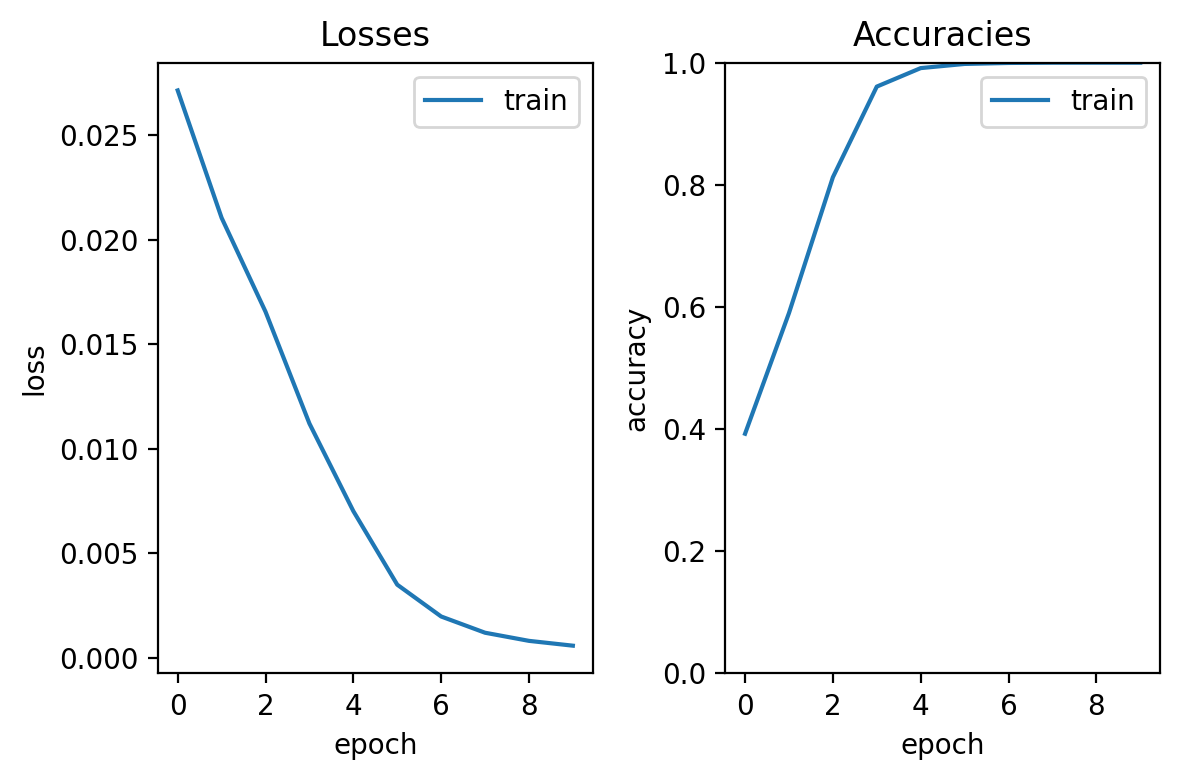

In [223]:
import time
start_time = time.time()

# TODO: initialize and train your model here.
# hidden size of 176 is where training starts working
# accuracy never 100% because of hidden state is always carried over
# from the previous batch, so first set of hidden inputs are not 0
model = GRU(27, 256, 27, 2, device, dropout=0.3)
#model = GRUMemory(27, 256, 27, 2, device)
model = model.to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.RMSprop(
    model.parameters(), lr=1e-3, alpha=0.99, eps=1e-08, weight_decay=0.0,
    momentum=0.0, centered=False)

N_EPOCH = 10
#with torch.autograd.set_detect_anomaly(True):
train(ds, N_EPOCH, model, optimizer, criterion, BATCH_SIZE, device)


In [224]:
def test_model(model, sequence_length=15, verbose=False):
  """
  This is the test function that runs 100 different strings through your model,
  and checks the error rate.
  """
  total = 0
  correct = 0
  for i in trange(5):
    s = ''.join([random.choice(string.ascii_lowercase)\
      for i in range(random.randint(15, 25))])
    result = model.test_run(s)
    assert DELAY > 0, 's[:-D] won\'t work for D=0'
    if verbose and i < 5:
      print(f'String: {s} Result: {result}')
    for c1, c2 in zip(s[:-DELAY], result[DELAY:]):
      correct += int(c1 == c2)
    total += len(s) - DELAY

  return correct / total

In [225]:

end_time = time.time()
duration = end_time - start_time
accuracy = test_model(model)
assert duration < 600, 'execution took f{duration:.2f} seconds, which longer than 10 mins'
assert accuracy > 0.99, f'accuracy is too low, got {accuracy}, need 0.99'
print('tests passed')

  0%|          | 0/5 [00:00<?, ?it/s]

tests passed


In [226]:
accuracy = test_model(model, verbose=True)
print(accuracy)


  0%|          | 0/5 [00:00<?, ?it/s]

String: svgtoefdpvrjyyfvjnuirxt Result:     svgtoefdpvrjyyfvjnu
String: fufwobjnjnuvekoqdwvlej Result:     fufwobjnjnuvekoqdw
String: xhzbwulbwmvqipdum Result:     xhzbwulbwmvqi
String: yriikxmfsikerlyy Result:     yriikxmfsike
String: rrguaoumeghaqqofvjy Result:     rrguaoumeghaqqo
1.0


## Variable delay model

Now, to make this more complicated, we want to have varialbe delay. So, now, the goal is to transform a sequence of pairs (character, delay) into a character sequence with given delay. Delay stays constant within one sequence.

### Dataset
As before, we first implement the dataset:

In [227]:
class VariableDelayEchoDataset(torch.utils.data.IterableDataset):

  def __init__(self, max_delay=8, seq_length=20, size=1000, batch_size=32):
    self.max_delay = max_delay
    self.seq_length = seq_length
    self.size = size
    self.batch_size = batch_size
  
  def __len__(self):
    return (self.size + self.batch_size - 1) // self.batch_size

  def __iter__(self):
    i = self.size
    while i > 0:
      batch = []
      input = []
      target = []
      delays = []
      for _ in range(self.batch_size):
        seq = torch.tensor(
          [random.choice(range(1, N + 1))
          for i in range(self.seq_length)], dtype=torch.int64)
        delay = random.randint(0, self.max_delay)
        result = torch.cat(
          (torch.zeros(delay), seq[:self.seq_length - delay])).type(torch.int64)
        input.append(seq)
        target.append(result)
        delays.append(delay)
        i -= 1
      # seq_len x batch_size
      input = torch.stack(input, dim=1)
      target = torch.stack(target, dim=1)
      # batch_size
      delays = torch.Tensor(delays)
      yield input, delays, target

### Model

And the model.

In [228]:
class VariableDelayGRUMemory(GRUBase):

  def __init__(
      self, input_size, hidden_size, output_size, max_delay, delay_size,
      num_layers, device):
    super().__init__(
      input_size, hidden_size, output_size, num_layers, device,
      delay_size=delay_size, batch_first=False)
    self.max_delay = max_delay
    assert num_layers > 0, 'Number of gru layers has to be atleast 1'
    self.layers = nn.ModuleList([GRULayer(
      input_size, hidden_size, delay_size, batch_first=self.batch_first)])
    for _ in range(num_layers-1):
      self.layers.append(
        GRULayer(hidden_size, hidden_size, batch_first=self.batch_first))
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x, delays):
    # inputs:
    # x - tensor of shape (seq_length, batch size, N + 1)
    # delays - tensor of shape (batch size)
    # returns:
    # logits (scores for softmax) of shape (seq_length, batch size, N + 1)
    assert self.h is not None
    batch_size = x.shape[1]
    assert self.h.shape[1] == batch_size,\
      f'X shape {x.shape} H shape {self.h.shape}'
    out = x
    for i in range(self.num_layers):
      layer = self.layers[i]
      delays = None if i > 0 else delays
      out, h = layer(out, self.h[i], delays)
      self.h[i] = h.detach()
    out = self.linear(out)
    return out


### Train

As before, you're free to do what you want, as long as training finishes within 10 minutes and accuracy is above 0.99 for delays between 0 and 8.

In [237]:
def test_variable_delay_model(model, seq_length=20):
  """
  This is the test function that runs 100 different strings through your model,
  and checks the error rate.
  """
  total = 0
  correct = 0
  for i in trange(500):
    s = ''.join(
      [random.choice(string.ascii_lowercase) for i in range(seq_length)])
    d = random.randint(0, model.max_delay)
    # print(f'String: {s} delay:{d}')
    result = model.test_run(s, d)
    if d > 0:
      z = zip(s[:-d], result[d:])
    else:
      z = zip(s, result)
    for c1, c2 in z:
      correct += int(c1 == c2)
    total += len(s) - d

  return correct / total

VariableDelayGRUMemory(
  (layers): ModuleList(
    (0): GRULayer(
      (gru_cell): GRUCell(
        (reset_gate): Linear(in_features=548, out_features=512, bias=True)
        (update_gate): Linear(in_features=548, out_features=512, bias=True)
        (hidden_gate): Linear(in_features=548, out_features=512, bias=True)
        (tanh): Tanh()
        (act): ReLU()
      )
    )
    (1): GRULayer(
      (gru_cell): GRUCell(
        (reset_gate): Linear(in_features=1024, out_features=512, bias=True)
        (update_gate): Linear(in_features=1024, out_features=512, bias=True)
        (hidden_gate): Linear(in_features=1024, out_features=512, bias=True)
        (tanh): Tanh()
        (act): ReLU()
      )
    )
  )
  (linear): Linear(in_features=512, out_features=27, bias=True)
)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

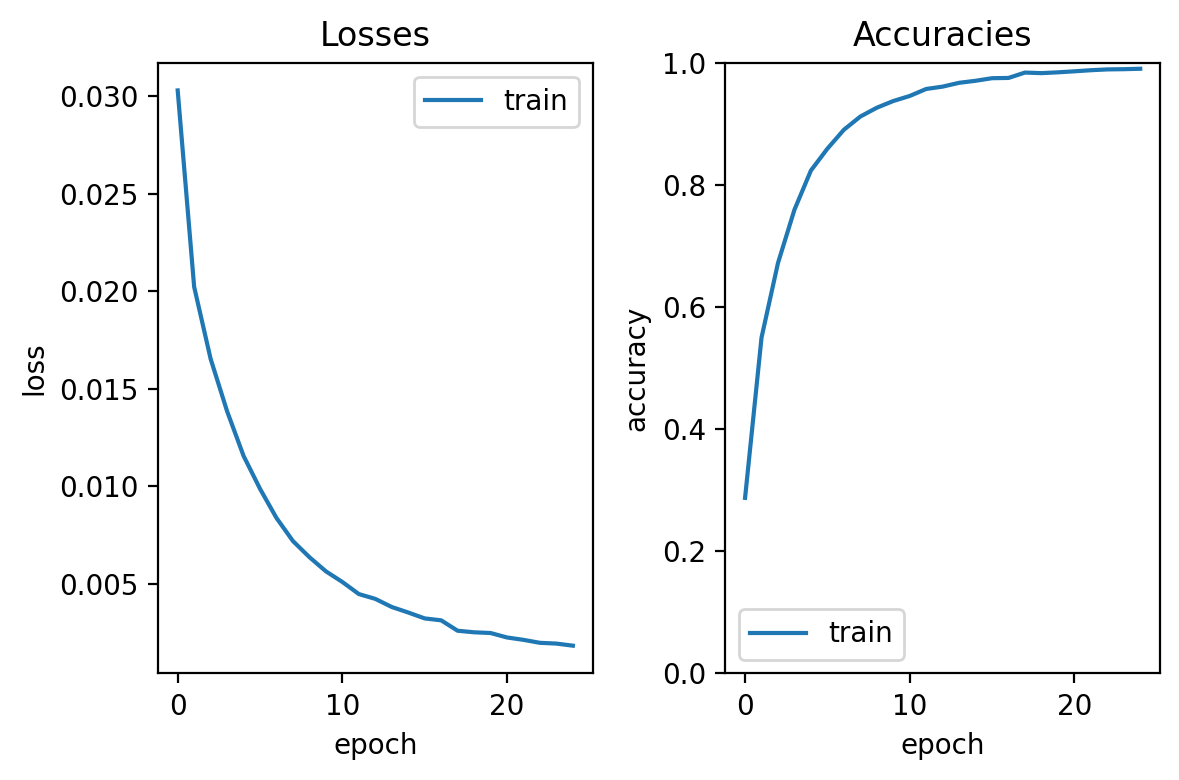

In [234]:
import time
start_time = time.time()

MAX_DELAY = 8
SEQ_LENGTH = 20
DELAY_SIZE = 9
BATCH_SIZE=32

var_ds = VariableDelayEchoDataset(
    max_delay=MAX_DELAY, seq_length=SEQ_LENGTH, size=DATASET_SIZE,
    batch_size=BATCH_SIZE)

model = VariableDelayGRUMemory(27, 512, 27, MAX_DELAY, DELAY_SIZE, 2, device)
model = model.to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.RMSprop(
    model.parameters(), lr=1e-3, alpha=0.99, eps=1e-08, weight_decay=0.0,
    momentum=0.0, centered=False)

N_EPOCH = 25
#with torch.autograd.set_detect_anomaly(True):
train(
    var_ds, N_EPOCH, model, optimizer, criterion, BATCH_SIZE, device,
    has_delay=True, batch_first=False, delay_size=DELAY_SIZE)

In [238]:

end_time = time.time()
assert end_time - start_time < 600, 'executing took longer than 10 mins'
assert test_variable_delay_model(model) > 0.99, 'accuracy is too low'
print('tests passed')

  0%|          | 0/500 [00:00<?, ?it/s]

tests passed


In [236]:
idx_to_onehot(torch.Tensor([0]), 9)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.]])